<a href="https://colab.research.google.com/github/Datkhoo25/insurance_risk_prediction/blob/main/5_RFE_DT_No_Impute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=300000)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import openpyxl
from scipy.stats import randint, uniform

from scipy.optimize import fmin_powell
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
!pip install -q -U keras-tuner
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import HeNormal, GlorotNormal, LecunNormal

from keras import regularizers
from keras.layers import Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam, SGD


import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

from keras.callbacks import History
from keras.callbacks import Callback, EarlyStopping
from keras.metrics import Accuracy, Recall, Precision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


<ipython-input-4-670abaa5fb26>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# Specify the path to your Excel file
workbook_path = '/content/drive/MyDrive/Colab Notebooks/Insurance Dataset/Preprocessing_Checkpoint/No_Impute_wNA_dt_rfe.xlsx'

# Load the workbook
wb = openpyxl.load_workbook(workbook_path)

# Get sheet names
sheet_names = wb.sheetnames

# Container for DataFrames
dfs = {}

# Iterate through each sheet
for sheet_name in sheet_names:
    print(f"\nSheet: {sheet_name}")
    sheet = wb[sheet_name]

    # Extract headers (first row)
    headers = [cell.value for cell in sheet[1]]
    # print(f"Headers: {headers}")

    # Extract data rows
    data = []
    for row in sheet.iter_rows(min_row=2, values_only=True):
        data.append(row)
    # print("Data:")
    # for row in data:
    #     print(row)

    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=headers)
    dfs[sheet_name] = df


Sheet: X_train_no_imp_wNA_dt_rfe

Sheet: X_val_no_imp_wNA_dt_rfe

Sheet: test_df_no_imp_wNA_dt_rfe

Sheet: y_train

Sheet: y_val


In [ ]:
# Access your DataFrames from the dictionary `dfs`
print("\nDataFrames:")
for name, df in dfs.items():
    print(f"\nDataFrame: {name}")
    name = df

print(sheet_names)


DataFrames:

DataFrame: X_train_no_imp_wNA_dt_rfe

DataFrame: X_val_no_imp_wNA_dt_rfe

DataFrame: test_df_no_imp_wNA_dt_rfe

DataFrame: y_train

DataFrame: y_val
['X_train_no_imp_wNA_dt_rfe', 'X_val_no_imp_wNA_dt_rfe', 'test_df_no_imp_wNA_dt_rfe', 'y_train', 'y_val']


In [ ]:
x_train, x_val, x_test, y_train, y_val = dfs.items()
x_train_m = x_train[1]
x_val_m = x_val[1]
x_test_m = x_test[1]
y_train_m = y_train[1]
y_val_m = y_val[1]

In [ ]:
x_train = x_train_m.astype(str).replace('=#NUM!', np.nan).apply(pd.to_numeric, errors='ignore')
x_val = x_val_m.astype(str).replace('=#NUM!', np.nan).apply(pd.to_numeric, errors='ignore')
x_test = x_test_m.astype(str).replace('=#NUM!', np.nan).apply(pd.to_numeric, errors='ignore')
y_train = y_train_m
y_val = y_val_m

In [ ]:
print(x_train_m.shape, y_train_m.shape)
print(x_val_m.shape, y_val_m.shape)


(47504, 200) (47504, 1)
(11877, 200) (11877, 1)


In [ ]:
y_train_m.max()

None    8
dtype: int64

Based on comparison with Preprocessing notebook, all the "=#Num1" was previously N/A. Thus, we will turn it back to N/A before the machine learning.

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
xgb = XGBClassifier()

XGBoost

In [ ]:
random_state = 42

# Define the parameter distributions
param_dist = {
    'max_depth': randint(10, 40),  # XGBClassifier parameters
    'min_child_weight': randint(0, 3),
    'subsample': uniform(0.5, 0.4),
    'colsample_bytree': uniform(0.5, 0.4),
    'learning_rate': uniform(0.1, 0.3),
    'n_estimators': randint(500, 1500)
}


xgb = XGBClassifier(objective='multi:softmax', num_class=8, n_jobs=-1)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=param_dist,
                                   n_iter=50,  # Number of parameter settings that are sampled
                                   scoring='accuracy',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(x_train, y_train_encoded)

# Print the best parameters and best score
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Predict on validation set with the best estimator
y_pred = best_xgb_model.predict(x_val)

# Evaluate accuracy with the best estimator
accuracy_best = accuracy_score(y_val_encoded, y_pred)
print(f"Accuracy on validation set with best estimator: {accuracy_best:.4f}")

# Evaluate precision with the best estimator
precision_best = precision_score(y_val_encoded, y_pred, average='micro')
print(f"Precision on validation set with best estimator: {precision_best:.4f}")

# Evaluate precision with the best estimator
recall_best = recall_score(y_val_encoded, y_pred, average='micro')
print(f"Recall on validation set with best estimator: {recall_best:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'colsample_bytree': 0.7473544037332349, 'learning_rate': 0.21473859738014883, 'max_depth': 29, 'min_child_weight': 0, 'n_estimators': 630, 'subsample': 0.8439761626945282}
Best cross-validation score: 0.5868558047983807
Accuracy on validation set with best estimator: 0.5957
Precision on validation set with best estimator: 0.5957
Recall on validation set with best estimator: 0.5957


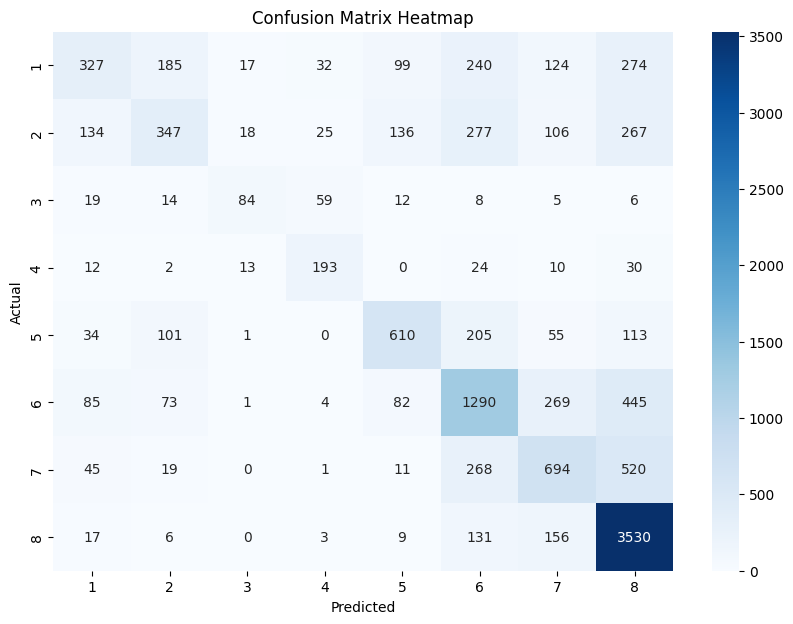

In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_pred)

# Create a DataFrame for the confusion matrix for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=[i+1 for i in range(len(conf_matrix))],
                              columns=[i+1 for i in range(len(conf_matrix))])

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

Random Forest can't accept value with NaN

ANN/DNN

In [ ]:
def build_model(hp):
    input_dim = x_train.shape[1]  # Assuming x_train is defined outside this function

    i_model = Sequential()
    i_model.add(Dense(100, input_dim=input_dim, activation='linear'))

    for each_layer in range(hp.Int("Dense Layers", min_value=1, max_value=4)):
        i_model.add(Dense(hp.Choice(f"layer_{each_layer}_filters", [30, 60, 90, 120]),
        activation=hp.Choice(f"layer_{each_layer}_activation", ['relu', 'sigmoid', 'tanh', 'linear']),
        kernel_regularizer=regularizers.l2(hp.Float("Regularizer_rate", min_value=0, max_value=0.1))))
        i_model.add(Dropout(rate=hp.Float("Dropout_rate", min_value=0, max_value=0.5)))


    i_model.add(Dense(8, activation='softmax'))

    i_model.compile(optimizer=Adam(learning_rate=0.1),
                    loss=sparse_categorical_crossentropy,
                    metrics='accuracy')

    return i_model

In [ ]:

tuner = RandomSearch(build_model, objective='accuracy', max_trials=50)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

tuner.search(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=40, batch_size=3, callbacks=[stop_early])



Trial 50 Complete [00h 02m 52s]
accuracy: 0.10333866626024246

Best accuracy So Far: 0.10333866626024246
Total elapsed time: 02h 27m 52s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print each hyperparameter and its value
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Dense Layers: 1
layer_0_filters: 30
layer_0_activation: relu
Regularizer_rate: 0.09188767742986698
Dropout_rate: 0.11056798437483073


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps}")

# Build and train best model
best_model = tuner.hypermodel.build(best_hps)
history3 = best_model.fit(
    x_train,
    y_train_encoded,
    validation_data=(x_val, y_val_encoded),
    epochs=50,
    batch_size=32,
    verbose=1,  # Ensure verbosity is set appropriately
    callbacks=[stop_early])

# Access training history
print(history3.history.keys())  # Print available metrics in history

Best hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7a0a80963460>
Epoch 1/50
1485/1485 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1033 - val_loss: nan - val_accuracy: 0.1093
Epoch 2/50
1485/1485 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.1033 - val_loss: nan - val_accuracy: 0.1093
Epoch 3/50
1485/1485 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.1033 - val_loss: nan - val_accuracy: 0.1093
Epoch 4/50
1485/1485 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.1033 - val_loss: nan - val_accuracy: 0.1093
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 640x480 with 0 Axes>

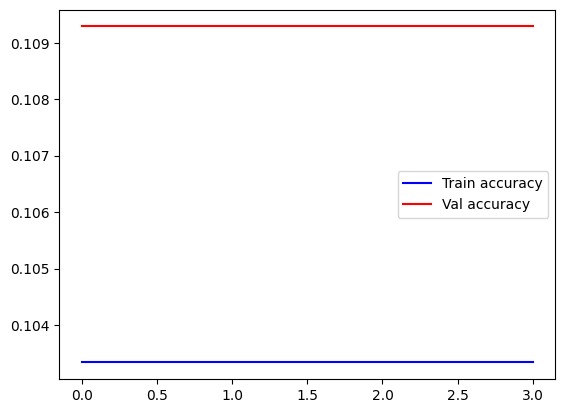

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
epochs_range3 = range(len(accuracy3))

import matplotlib.pyplot as plt

plt.plot(epochs_range3, accuracy3,'b',label='Train accuracy')
plt.plot(epochs_range3, val_accuracy3,'r',label='Val accuracy')
plt.legend()
plt.figure()

In [ ]:
# Assuming y_pred is obtained from best_model.predict(x_val)
y_pred3 = best_model.predict(x_val)

# Convert y_pred probabilities to integer labels
y_pred_labels3 = np.argmax(y_pred3, axis=1)

# Compute metrics with integer labels
accuracy3 = accuracy_score(y_val_encoded, y_pred_labels3)
print(f"Accuracy: {accuracy3}")

precision3 = precision_score(y_val_encoded, y_pred_labels3, average='micro')
print(f"Precision: {precision3}")

recall3 = recall_score(y_val_encoded, y_pred_labels3, average='micro')
print(f"Recall: {recall3}")

372/372 [==============================] - 1s 2ms/step
Accuracy: 0.10928685695040835
Precision: 0.10928685695040835
Recall: 0.10928685695040835
